# Organ Retrieval and Collection of Health Information for Donation (ORCHID)

The aim of this notebook is to get set up with access to the [ORCHID Database]( https://doi.org/10.13026/eytj-4f29).

In [1]:
# Installation
!pip install tableone

In [7]:
# Suppress deprectation warnings
# Prevents ipykernel/ipkernel.py:283: DeprecationWarning:
# `should_run_async` will not call `transform_cell` automatically in the future.
# Please pass the result to `transformed_cell` argument and any exception that
# happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
# and should_run_async(code)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import seaborn as sns
from tableone import tableone

# Make pandas dataframes prettier
from IPython.display import display, HTML

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# Authenticating with Google Cloud

Before running any queries, you need to first authenticate by running the following cell. If you are running it for the first time, it will ask you to follow a link to log in using your Gmail account, and accept the data access requests to your profile. Once this is done, it will generate a string of verification code, which you should paste back to the cell below and press enter.

In [9]:
auth.authenticate_user()

We will also set the `project_id`, which is used for billing purposes. Any costs associated with the analyses will be billed against the owner of the project.

In [10]:
project_id='physionet-data'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

# "Querying" our database

Now we can start exploring the data. We'll begin by running a simple query to load all columns of the `patient` table to a Pandas DataFrame. The query is written in SQL, a common language for extracting data from databases. The structure of an SQL query is:

```sql
SELECT <columns>
FROM <table>
WHERE <criteria, optional>
```

Instead of specifying the name of each column, we can use `SELECT *` to select all columns.

# Extracting data from BigQuery

Our dataset is stored on BigQuery, Google's database engine. We can run our query on the database using some special ("magic") [BigQuery syntax](https://googleapis.dev/python/bigquery/latest/magics.html).

In [11]:
%%bigquery opo

SELECT *
FROM `physionet-data.orchid_v1_0_0.opo`
# LIMIT 1000

Query is running:   0%|          |

Downloading:   0%|          |

In [12]:
print(f"Number of rows: {len(opo)}")
print(f"Number of columns: {len(opo.columns)}")

Number of rows: 133101
Number of columns: 34


We have now assigned the output to our query to a variable called `opo`. Let's use the `head` method to view the first few rows of our data.

In [13]:
# view the top few rows of the patient data
opo.head(3)

,OPO,PatientID,Age,Gender,Race,HospitalID,brain_death,Cause_of_Death_OPO,Cause_of_Death_UNOS,Mechanism_of_Death,...,Referral_Year,Procured_Year,outcome_heart,outcome_liver,outcome_kidney_left,outcome_kidney_right,outcome_lung_left,outcome_lung_right,outcome_intestine,outcome_pancreas
0,OPO1,OPO1_P320866,62.0,M,White / Caucasian,OPO1_H23456,False,None,Head Trauma,None,...,2018,NaN,None,None,None,None,None,None,None,None
1,OPO1,OPO1_P549364,14.0,F,White / Caucasian,OPO1_H11908,False,None,None,None,...,2021,NaN,None,None,None,None,None,None,None,None
2,OPO1,OPO1_P284978,80.0,F,White / Caucasian,OPO1_H5832,False,None,None,None,...,2018,NaN,None,None,None,None,None,None,None,None


# Adding derived columns

Let's add some derived features to our dataset, for example weekend vs weekday and hours between referral and approach.

In [14]:
# View existing columns
print(opo.columns)

Index(['OPO', 'PatientID', 'Age', 'Gender', 'Race', 'HospitalID',
       'brain_death', 'Cause_of_Death_OPO', 'Cause_of_Death_UNOS',
       'Mechanism_of_Death', 'Circumstances_of_Death', 'approached',
       'authorized', 'procured', 'transplanted', 'Tissue_Referral',
       'Eye_Referral', 'time_asystole', 'time_brain_death', 'time_referred',
       'time_approached', 'time_authorized', 'time_procured',
       'Referral_DayofWeek', 'Referral_Year', 'Procured_Year', 'outcome_heart',
       'outcome_liver', 'outcome_kidney_left', 'outcome_kidney_right',
       'outcome_lung_left', 'outcome_lung_right', 'outcome_intestine',
       'outcome_pancreas'],
      dtype='object')


In [15]:
# Add a weekend vs weekday column
opo['weekday_or_weekend'] = np.where(opo.Referral_DayofWeek.isin(['Saturday', 'Sunday']), 'weekend','weekday')
opo['weekday_or_weekend'].value_counts()

weekday    96741
weekend    36360
Name: weekday_or_weekend, dtype: int64

In [16]:
# Add hours to approach column
opo['hours_to_approach'] = (opo.time_approached - opo.time_referred).dt.total_seconds() / (3600.)

# Set outliers to NaN
opo['hours_to_approach'] = np.where(np.logical_or(opo['hours_to_approach'] < -24, opo['hours_to_approach'] > 24*4),
                                    np.nan, opo['hours_to_approach'])

opo['hours_to_approach'].describe()

count    18330.000000
mean        30.785583
std         24.870545
min        -23.195844
25%          9.765854
50%         24.381992
75%         47.050679
max         95.966600
Name: hours_to_approach, dtype: float64

In [17]:
# Add hours to procurement column
opo['hours_to_procurement'] = (opo.time_procured - opo.time_referred).dt.total_seconds() / (3600.)

# Set outliers to NaN
opo['hours_to_procurement'] = np.where(np.logical_or(opo['hours_to_procurement'] < -24, opo['hours_to_procurement'] > 24*4),
                                    np.nan, opo['hours_to_procurement'])

opo['hours_to_procurement'].describe()

count    5908.000000
mean       63.516756
std        19.893224
min        -1.583643
25%        50.431526
50%        64.971083
75%        79.472547
max        95.986946
Name: hours_to_procurement, dtype: float64

In [18]:
# Add hours from approach to authorization column
opo['hours_to_authorization'] = (opo.time_authorized - opo.time_approached).dt.total_seconds() / (3600.)

# Set outliers to NaN
opo['hours_to_authorization'] = np.where(np.logical_or(opo['hours_to_authorization'] < -24, opo['hours_to_authorization'] > 24*4),
                                    np.nan, opo['hours_to_authorization'])

opo['hours_to_authorization'].describe()

count    19382.000000
mean         2.914965
std          8.900187
min        -24.000000
25%          0.000000
50%          0.000000
75%          1.433333
max         96.000000
Name: hours_to_authorization, dtype: float64

In [19]:
# Add age bin column
# Define custom bin edges and labels
bin_edges = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Create the 'age_bin' column with custom bin labels
opo['age_bin'] = pd.cut(opo['Age'], bins=bin_edges, labels=bin_labels, right=False)
opo[['Age', 'age_bin']].head()

,Age,age_bin
0,62.0,61-70
1,14.0,11-20
2,80.0,81-90
3,76.0,71-80
4,62.0,61-70


In [20]:
# Add time of referral bin

# Define custom bin edges and labels
bin_edges = list(range(1, 25))  # Bins from 1 to 24
bin_labels = [f"{start}-{end}" for start, end in zip(bin_edges[:-1], bin_edges[1:])]

# Extract the hour component from the 'time_of_day' column
opo['hour_of_referral'] = opo['time_referred'].apply(lambda x: x.hour)
opo['hour_of_referral_bin'] = pd.cut(opo['hour_of_referral'], bins=bin_edges, labels=bin_labels, right=False)
opo[['hour_of_referral_bin']].head()

,hour_of_referral_bin
0,6-7
1,8-9
2,4-5
3,21-22
4,15-16


In [21]:
# Define custom bin edges and labels
bin_edges = list(range(1, 25, 4))  # Bins from 1 to 24
bin_labels = [f"{start}-{end}" for start, end in zip(bin_edges[:-1], bin_edges[1:])]

# Extract the hour component from the 'time_of_day' column
opo['hour_of_referral_bin_4'] = pd.cut(opo['hour_of_referral'], bins=bin_edges, labels=bin_labels, right=False)
opo[['hour_of_referral_bin_4']].head()

,hour_of_referral_bin_4
0,5-9
1,5-9
2,1-5
3,NaN
4,13-17


In [22]:
# Add day or night of referral bin
opo['day_or_night_referral'] = np.where((opo['hour_of_referral'] >= 6) & (opo['hour_of_referral'] < 18), 'Day', 'Night')
opo[['day_or_night_referral']].head()

,day_or_night_referral
0,Day
1,Day
2,Night
3,Night
4,Day


# Cleaning

In [23]:
# Remove weird 516 values
opo['outcome_kidney_left'] = np.where(opo['outcome_kidney_left'] == '516',
                                      np.nan, opo['outcome_kidney_left'])

opo['outcome_lung_left'] = np.where(opo['outcome_kidney_left'] == '516',
                                    np.nan, opo['outcome_kidney_left'])

opo['outcome_lung_right'] = np.where(opo['outcome_kidney_left'] == '516',
                                     np.nan, opo['outcome_kidney_left'])

opo['outcome_pancreas'] = np.where(opo['outcome_kidney_left'] == '516',
                                   np.nan, opo['outcome_kidney_left'])


# Visualize the data

In [24]:
def plot_density(df, x, hue, xmin, xmax):
    """
    Creates a stratified density plot.
    """
    # Set the figure size
    plt.figure(figsize=[6, 4])

    # Create a KDE plot for each category in the 'hue' column
    sns.kdeplot(data=opo, x=x, hue=hue, fill=True, common_norm=False)

    # Set the x-axis limits
    plt.xlim([xmin, xmax])

    # Add labels and legend
    plt.xlabel(x)
    plt.ylabel('Density')
    plt.title(f'{x},\n by {hue}')

    # Show the plot
    plt.show()

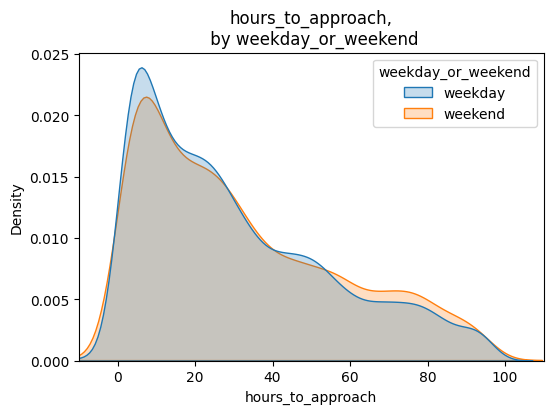

In [ ]:
plot_density(df=opo, x='hours_to_approach', hue='weekday_or_weekend',
             xmin=-10, xmax=110)

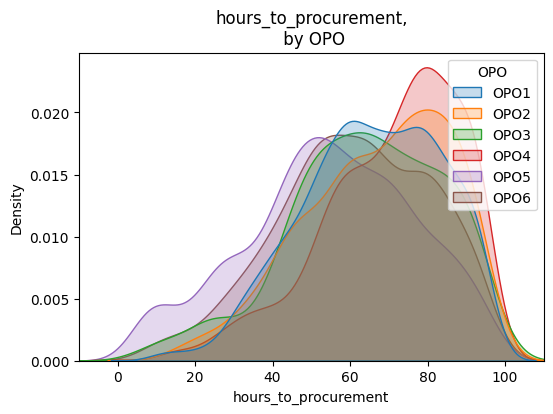

In [ ]:
plot_density(df=opo, x='hours_to_procurement', hue='OPO',
             xmin=-10, xmax=110)

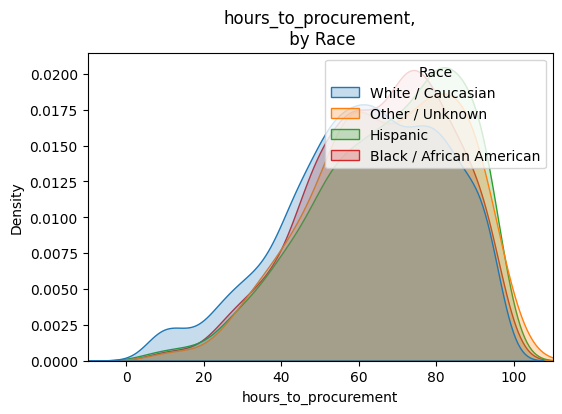

In [ ]:
plot_density(df=opo, x='hours_to_procurement', hue='Race',
             xmin=-10, xmax=110)

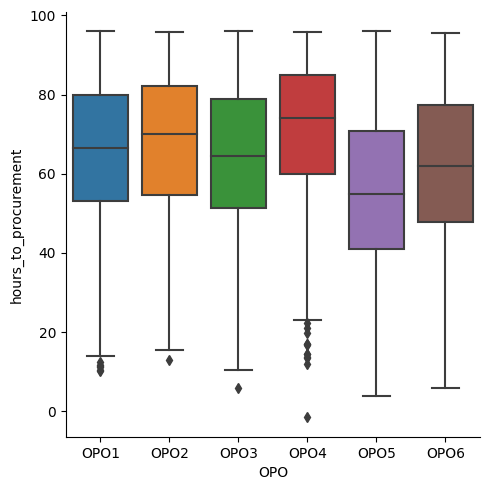

In [30]:
# Categorical plot. Kind includes: box, boxen, violin
sns.catplot(data=opo, y="hours_to_procurement", x="OPO", kind="box")

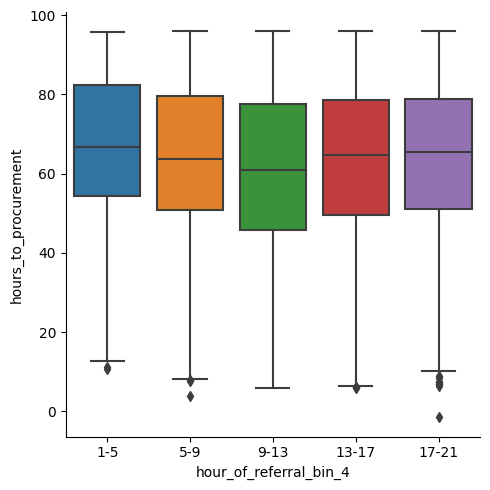

In [ ]:
sns.catplot(data=opo, y="hours_to_procurement", x="hour_of_referral_bin_4", kind="box")

# Summary statistics

In [31]:
columns = ['OPO', 'Age', 'Gender', 'Race', 'brain_death', 'Cause_of_Death_OPO',
           'Cause_of_Death_UNOS', 'Mechanism_of_Death', 'Circumstances_of_Death',
           'approached', 'authorized', 'procured', 'transplanted', 'Tissue_Referral',
           'Eye_Referral', 'Referral_DayofWeek', 'Referral_Year', 'weekday_or_weekend',
           'Procured_Year', 'outcome_heart', 'outcome_liver', 'hours_to_approach',
           'outcome_kidney_left', 'outcome_kidney_right', 'outcome_lung_left',
           'outcome_lung_right', 'outcome_intestine', 'outcome_pancreas']
continuous = ['Age', 'hours_to_approach']
categorical = [x for x in columns if x not in continuous]
groupby = "transplanted"

In [32]:
table = tableone(opo, groupby=groupby, columns=columns, categorical=categorical,
                 limit=50, pval=True)

/usr/local/lib/python3.10/dist-packages/tableone/tableone.py:1449: UserWarning: Order variable not found: age_bin
  warnings.warn("Order variable not found: {}".format(k))
/usr/local/lib/python3.10/dist-packages/tableone/tableone.py:1449: UserWarning: Order variable not found: hour_of_referral_bin
  warnings.warn("Order variable not found: {}".format(k))
/usr/local/lib/python3.10/dist-packages/tableone/tableone.py:1449: UserWarning: Order variable not found: hour_of_referral_bin_4
  warnings.warn("Order variable not found: {}".format(k))


In [33]:
print(table.tabulate(tablefmt = "fancy_grid"))

╒═══════════════════════════════╤══════════════════════════════════════════════════╤═══════════╤═══════════════╤════════════════╤══════════════╤═══════════╕
│                               │                                                  │ Missing   │ Overall       │ False          │ True         │ P-Value   │
╞═══════════════════════════════╪══════════════════════════════════════════════════╪═══════════╪═══════════════╪════════════════╪══════════════╪═══════════╡
│ n                             │                                                  │           │ 133101        │ 124129         │ 8972         │           │
├───────────────────────────────┼──────────────────────────────────────────────────┼───────────┼───────────────┼────────────────┼──────────────┼───────────┤
│ OPO, n (%)                    │ OPO1                                             │ 0         │ 32148 (24.2)  │ 29590 (23.8)   │ 2558 (28.5)  │ <0.001    │
├───────────────────────────────┼─────────────────────────